In [ ]:
import pandas as pd
ecom = pd.read_csv('Womens_Clothing_E_Commerce_Reviews.csv')

ecom = ecom.drop(['Unnamed: 0'],axis=1)
ecom = ecom.drop(columns = 'Clothing ID')
ecom.columns = ['age','title','review_text','Rating','recomended_ind','+feedback_cnt','division_name',
                'department','class_name']

for i in ecom.columns[ecom.isna().any()].tolist():
    print(i,"has",ecom[ecom[i].isna()==True].shape[0],"null values")

title has 3810 null values
review_text has 845 null values
division_name has 14 null values
department has 14 null values
class_name has 14 null values


In [ ]:
ecom['Class']='bad'
ecom.loc[ecom.Rating>3,['Class']]='good'

def ret_rating(rating):
    if rating >3:
        return 'good'
    else:
        return 'bad'

In [ ]:
ecom.head()

,age,title,review_text,Rating,recomended_ind,+feedback_cnt,division_name,department,class_name,Class
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,good
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,good
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,bad
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,good
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,good


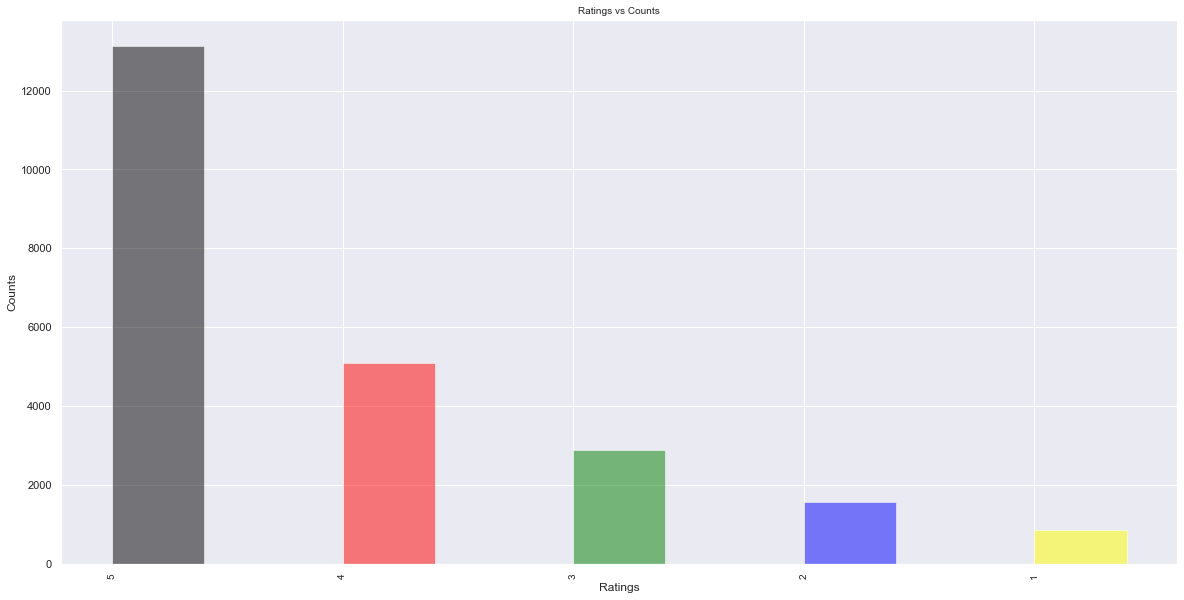

In [ ]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

abc1= ecom.groupby(['Rating'])['Rating'].agg({'counts':'count'})
abc1= abc1.sort_values(['counts'],ascending=False)
plt.rcParams["figure.figsize"] = (20,10)
y_pos = np.arange(len(abc1.index))
counts = abc1['counts'].tolist()
plt.bar(y_pos,counts,align='edge',width=0.4,alpha=0.5,color=['black','red','green','blue','yellow'])
plt.xticks(y_pos,abc1.index,rotation=90,fontsize=10)
plt.ylabel('Counts')
plt.xlabel('Ratings')
plt.title('Ratings vs Counts',fontsize=10)
plt.show()

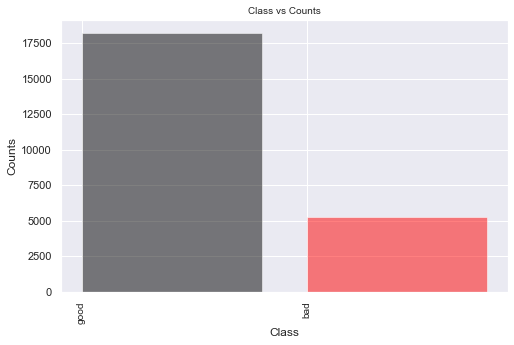

In [ ]:
abc1= ecom.groupby(['Class'])['Class'].agg({'counts':'count'})
abc1= abc1.sort_values(['counts'],ascending=False)
plt.rcParams["figure.figsize"] = (8,5)
y_pos = np.arange(len(abc1.index))
counts = abc1['counts'].tolist()
plt.bar(y_pos,counts,align='edge',alpha=0.5,color=['black','red','green','blue','yellow'])
plt.xticks(y_pos,abc1.index,rotation=90,fontsize=10)
plt.ylabel('Counts')
plt.xlabel('Class')
plt.title('Class vs Counts',fontsize=10)
plt.show()

In [ ]:
Age_List = pd.DataFrame(columns=['Age_Group','total_reviews','good','bad'])
ag_list=[]
for i in [[18,25],[26,30],[31,40],[41,50],[51,60],[61,70],[71,100]]:
    ag_list.append([str(i[0])+'-'+str(i[1]),ecom[(ecom.age>=i[0]) & (ecom.age<i[1])]['Class'].count(),
                   ecom[(ecom.age>=i[0]) & (ecom.age<i[1])].groupby('Class')['Class'].count()['good'] , ecom[(ecom.age>=i[0]) & (ecom.age<i[1])].groupby('Class')['Class'].count()['bad'] ])
Age_List = Age_List.append(pd.DataFrame(ag_list,columns=['Age_Group','total_reviews','good','bad']),ignore_index=True)
Age_List

,Age_Group,total_reviews,good,bad
0,18-25,892,733,159
1,26-30,1708,1271,437
2,31-40,7295,5585,1710
3,41-50,5510,4230,1280
4,51-60,3550,2822,728
5,61-70,1964,1589,375
6,71-100,380,302,78


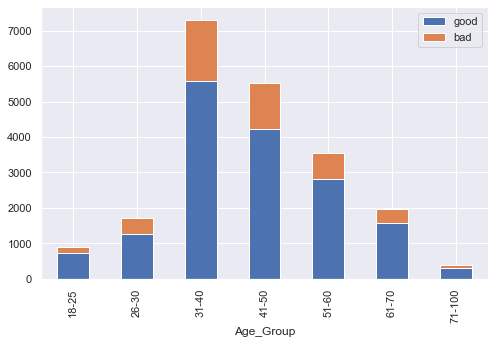

In [ ]:
sns.set()
Age_List[['Age_Group','good','bad']].set_index('Age_Group').plot(kind='bar',stacked=True)

In [ ]:
Rec_List = pd.DataFrame(columns=['Class','ind1_cnt','ind0_cnt'])
Rc_list=[]
for i in list([[1,0,'good'],[1,0,'bad']]):
    Rc_list.append([i[2],ecom[(ecom.Class==i[2]) & (ecom.recomended_ind==int(i[0]))]['Class'].count(),ecom[(ecom.Class==i[2]) & (ecom.recomended_ind==int(i[1]))]['Class'].count()])
Rec_List=Rec_List.append(pd.DataFrame(Rc_list , columns=['Class','ind1_cnt','ind0_cnt']))
Rec_List

,Class,ind1_cnt,ind0_cnt
0,good,18015,193
1,bad,1299,3979


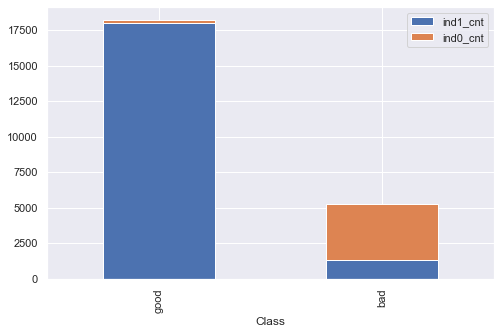

In [ ]:
sns.set()
Rec_List[['Class','ind1_cnt','ind0_cnt']].set_index('Class').plot(kind='bar', stacked=True)

In [ ]:
ecomc=ecom.copy()
ecomc=ecom.dropna(subset=['review_text'])

In [ ]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleaner=re.compile('<.*?>')
    cleantext=re.sub(cleaner,' ',sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

[nltk_data] Downloading package stopwords to C:\Users\Utkarsh
[nltk_data]     Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import os
from tqdm import tqdm
import sqlite3

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

if not os.path.isfile('cleaned_final.sqlite'):
    final_string=[]
    all_pos_words=[]
    all_neg_words=[]
    for i, sent in enumerate(tqdm(ecomc['review_text'].values)):
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
    
    ecomc['CleanedText']=final_string
    ecomc['CleanedText']=ecomc['CleanedText'].str.decode("utf-8")
    
    conn = sqlite3.connect('cleaned_final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    ecomc.to_sql('Reviews',conn, schema=None, if_exists='replace',\
                index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [ ]:
import os 
if os.path.isfile('cleaned_final.sqlite'):
    conn = sqlite3.connect('cleaned_final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)
    conn.close()
else:
    print("Please run the above cell")
    

In [ ]:
final.rename(columns={'class':'Class'},inplace=True)
final.head()

,index,age,title,review_text,Rating,recomended_ind,+feedback_cnt,division_name,department,class_name,Class,CleanedText
0,0,33,None,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,good,absolut wonder silki and sexi and comfort
1,1,34,None,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,good,love this dress it sooo pretti happen find sto...
2,2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,bad,had such high hope for this dress and realli w...
3,3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,good,love love love this jumpsuit it fun flirti and...
4,4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,good,this shirt veri flatter all due the adjust fro...


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [ ]:
x_train1 ,x_test1 = train_test_split(final[['CleanedText','recomended_ind']],test_size=0.2)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit_transform(x_train1['CleanedText'])
final_tf_idf = tf_idf_vect.transform(final['CleanedText'].values)
print("the shape of out text TFIDF vectorizer",final_tf_idf.get_shape())
print("the number of unique words",final_tf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer (22641, 180167)
the number of unique words 180167


In [ ]:
import scipy
from scipy.sparse import hstack
Final_Data = hstack((final_tf_idf,scipy.sparse.csr_matrix(final['recomended_ind']).T))

In [ ]:
final['Class_Ind']=1
final.loc[final.Class=='bad',['Class_Ind']]=0

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
Final_Data.shape

(22641, 180168)

In [ ]:
X_tr, X_test, y_tr, y_test = train_test_split(Final_Data,final['Class_Ind'],test_size=0.3,random_state=0)

In [ ]:
C = [10**x for x in range(-4,4)]
tuned_parameters = [{'alpha':C}]
model = GridSearchCV(BernoulliNB(binarize=0.0, class_prior=None, fit_prior=True), tuned_parameters, scoring='f1_macro', cv=5, return_train_score=True)
model.fit(X_tr, y_tr)
cv_score = model.cv_results_['mean_test_score']
train_score = model.cv_results_['mean_train_score']

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
PD_VALUES = model.predict(X_test)
f1_score(y_test, PD_VALUES, average='macro')

0.838454621246632

In [ ]:
PD_VALUES_TRN = model.predict(X_tr)

In [ ]:
accuracy_score(y_tr, PD_VALUES_TRN)

0.992238768298839

In [ ]:
accuracy_score(y_test, PD_VALUES)

0.8826733402031502

In [ ]:
cm = metrics.confusion_matrix(y_test, PD_VALUES)
print(cm)

[[1221  384]
 [ 413 4775]]


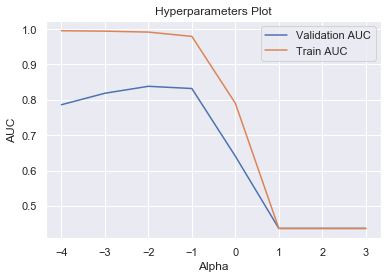

In [ ]:
import math
plt.plot(np.log10(C), cv_score, label="Validation AUC")
plt.plot(np.log10(C), train_score, label="Train AUC")
plt.ylabel('AUC')
plt.xlabel('Alpha')
plt.title('Hyperparameters Plot')
plt.legend()
plt.show()

In [ ]:
alpha1 = [10**x for x in range(-4,4)]
from sklearn.linear_model import SGDClassifier
tuned_parameters = [{'alpha': alpha1}]
model = GridSearchCV(SGDClassifier(loss='hinge', penalty='l1'), tuned_parameters, scoring='roc_auc', cv=5, return_train_score=True)
model.fit(X_tr, y_tr)
cv_score = model.cv_results_['mean_test_score']
train_score = model.cv_results_['mean_train_score']

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
PD_VALUES = model.predict(X_test)
print('test f1 score',f1_score(y_test, PD_VALUES, average='macro'))
PD_VALUES_TRN = model.predict(X_tr)
print('train accuracy', accuracy_score(y_tr, PD_VALUES_TRN))
print('test accuracy', accuracy_score(y_test, PD_VALUES))

test f1 score 0.8995785979988791
train accuracy 0.9362064613831398
test accuracy 0.9330192845576328


In [ ]:
cm = metrics.confusion_matrix(y_test, PD_VALUES)
print(cm)

[[1209  396]
 [  59 5129]]


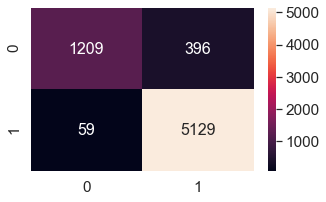

In [ ]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(2),
                    range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

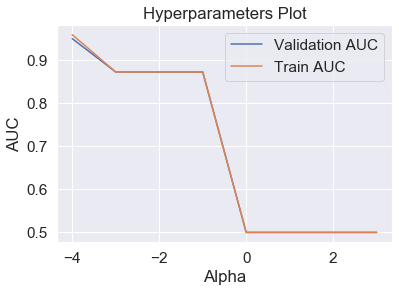

In [ ]:
import math
plt.plot(np.log10(C), cv_score, label="Validation AUC")
plt.plot(np.log10(C), train_score, label="Train AUC")
plt.ylabel('AUC')
plt.xlabel('Alpha')
plt.title('Hyperparameters Plot')
plt.legend()
plt.show()